In [1]:
import os
import torch
import numpy as np
from matplotlib import pyplot as plt

In [42]:
from smaller_model import UNet
import PIL.Image as Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

def plot_img(img):
    plt.imshow(img, cmap='gray')
    plt.axis('off')

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    max_pixel = np.max(img1)
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

transforms = T.Compose([
    T.ToTensor(),
    T.CenterCrop(224)
])

model = UNet()

state_dict = torch.load('./checkpoints/model_8.pth')
model.load_state_dict(state_dict)

img = Image.open('/home/danny/datasets/ILSVRC/Data/train/n01440764/n01440764_10026.JPEG').convert('L')
img = np.array(img)
std = np.random.uniform(0, 1)
noise = np.random.normal(0, std, size=img.shape)

noisy_img = transforms(img + noise)
noisy_img2 = transforms(img.copy() + noise)

example = torch.cat((noisy_img, noisy_img2), dim=0).to(torch.float)
example.shape

torch.Size([2, 224, 224])

In [52]:
pred = model(example.unsqueeze(dim=0)).squeeze(dim=0).detach().numpy()
cropped_image = transforms(img).squeeze(0).detach().numpy()
print(pred.shape)

(2, 224, 224)


38.82542610168457


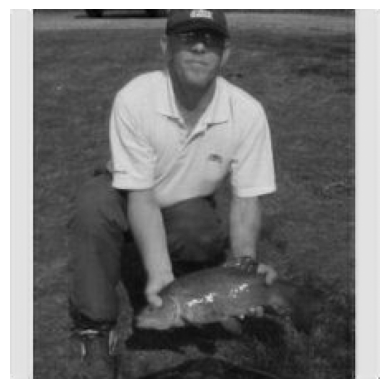

In [58]:
plot_img(pred[0])
print(calculate_psnr(pred, cropped_image))

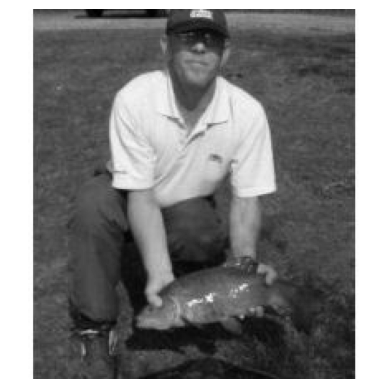

In [41]:
plot_img(noisy_img.permute((1, 2, 0)))

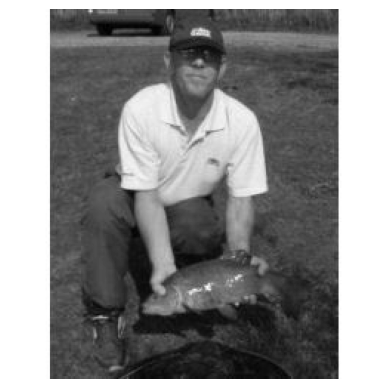

In [15]:
plot_img(img)